## This notebook is used for testing MTAOS communication with the AOS components: M1M3, M2, and hexapods

Step-by-step description of what we do can be found in 
Jira test case: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T???? 

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.idl.enums import MTM1M3

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

<Figure size 432x288 with 0 Axes>

In [2]:
#summit = 1 #use this for summit testing
summit = 0 #use this for NCSA

In [5]:
#Tiago suggested not to run this on the summit; this is only for NCSA debugging DDS
#For the summit M1M3 test, remember to set up the daemon on the command line!!!
if not summit:
    import os
    print(os.environ["OSPL_URI"])
    if os.environ.get("LSST_DDS_ALIGNER", "false") != "false":
        print("LSST_DDS_ALIGNER is mis-configured")

file:///home/bxin/ts_ddsconfig/config/ospl-sp.xml


In [4]:
start_time = datetime.now()
script = salobj.Controller("Script", index=1)
if not summit:
    await asyncio.sleep(10) #not need to wait on summit since we use the daemon
    ptg = salobj.Remote(script.domain, "MTPtg")
    rot = salobj.Remote(script.domain, "MTRotator")
mount = salobj.Remote(script.domain, "MTMount") #we still need it on the summit, to check fake mount telemetry!
m1m3 = salobj.Remote(script.domain, "MTM1M3", exclude=['logMessage'])
m2 = salobj.Remote(script.domain, "MTM2", exclude=['logMessage'])
camhex = salobj.Remote(script.domain, "MTHexapod", index=1) #1 for camera hexapod and 2 for m2 hexapod
m2hex = salobj.Remote(script.domain, "MTHexapod", index=2) 
aos = salobj.Remote(script.domain, "MTAOS")
print(f'time to start is {datetime.now() - start_time} [s]')

time to start is 0:00:41.043451 [s]


rotation DDS read queue is full (100 elements); data may be lost
motors DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is full (100 elements); data may be lost
application DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 27 of 100 elements
electrical DDS read queue is filling: 49 of 100 elements
application DDS read queue is filling: 28 of 100 elements
timeAndDate DDS read queue is full (100 elements); data may be lost
elevation DDS read queue is full (100 elements); data may be lost
application DDS read queue is filling: 50 of 100 elements
actuators DDS read queue is filling: 28 of 100 elements
powerSupplyData DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 50 of 100 elements
cameraCableWrap DDS read queue is full (100 elements); data may be lost
mountStatus DDS read queue is full (100 elements); data may be lost
inclinometerData DDS read queue is full (100 elem

In [6]:
if summit:
    await asyncio.gather(mount.start_task,
                         m1m3.start_task,
                         m2.start_task,
                         camhex.start_task,
                         m2hex.start_task,
                         aos.start_task
                        )
else:
    await asyncio.gather(ptg.start_task,
                         mount.start_task,
                         script.start_task, #                     
                         rot.start_task,
                         m1m3.start_task,
                         m2.start_task,
                         camhex.start_task,
                         m2hex.start_task,
                         aos.start_task)

In [7]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

In [8]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [7]:
await salobj.set_summary_state(aos, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [8]:
await salobj.set_summary_state(aos, salobj.State.ENABLED) #, settingsToApply='default') #leave this out!!

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

#### Check summary state of each CSC

In [9]:
#aos
sstate = await aos.evt_summaryState.aget(timeout=5)
print('starting with: MTAOS state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))

#m1m3
sstate = await m1m3.evt_summaryState.aget(timeout=5)
print('starting with: M1M3 state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))
dstate = await m1m3.evt_detailedState.aget(timeout=200)
print('          m1m3 state', MTM1M3.DetailedState(dstate.detailedState), pd.to_datetime(dstate.private_sndStamp, unit='s'))

#m2
sstate = await m2.evt_summaryState.aget(timeout=5)
print('staring with: m2 state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))

#camhex
state = await camhex.evt_summaryState.aget(timeout=5)
print('staring with: cam hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))

#m2hex
state = await m2hex.evt_summaryState.aget(timeout=5)
print('staring with: M2 hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))

starting with: MTAOS state State.ENABLED 2021-04-08 18:26:37.929211136
starting with: M1M3 state State.ENABLED 2021-04-07 00:13:57.520275200
          m1m3 state DetailedState.ACTIVE 2021-04-07 00:13:57.520360448
staring with: m2 state State.ENABLED 2021-04-06 22:12:19.794305280
staring with: cam hex state State.ENABLED 2021-04-05 23:22:16.231733248
staring with: M2 hex state State.ENABLED 2021-04-06 00:57:41.922568192


### Get M1M3 Ready: raise mirorr, turn on FB, clear forces

In [10]:
if sstate.summaryState == salobj.State.ENABLED:
    await salobj.set_summary_state(m1m3, salobj.State.DISABLED) #disable m1m3
if sstate.summaryState == salobj.State.FAULT:
    await m1m3.cmd_clearErrors.set_start()
if sstate.summaryState == salobj.State.STANDBY:
    await m1m3.cmd_start.set_start(settingsToApply="Default")
await salobj.set_summary_state(m1m3, salobj.State.ENABLED) #enable m1m3

RuntimeError: Error on cmd=cmd_disable, initial_state=2: msg='Command failed', ackcmd=(ackcmd private_seqNum=539811678, ack=<SalRetCode.CMD_FAILED: -302>, error=0, result='Failed: The command Disable is not valid in the ActiveState.')

In [10]:
m1m3Angle = await m1m3.tel_inclinometerData.next(flush=True, timeout=5)
print("m1m3Angle", m1m3Angle.inclinometerAngle)

m1m3Angle 80.00299835205078


In [11]:
m1m3HP = await m1m3.tel_hardpointActuatorData.aget()
print("m1m3 z", m1m3HP.zPosition)

m1m3 z 0.0


In [9]:
await raiseM1M3(m1m3)

m1m3 state DetailedState.RAISING 2021-04-09 17:57:44.960255232
m1m3 state DetailedState.ACTIVE 2021-04-09 17:58:38.394564352


In [14]:
#If magnitude = 0.0 then it is off
m1m3ForceBalance = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
print("starting with magnitude of the m1m3 balance force ---", m1m3ForceBalance.forceMagnitude, "----",
      pd.to_datetime(m1m3ForceBalance.private_sndStamp, unit='s'))

starting with magnitude of the m1m3 balance force --- 1635.0618896484375 ---- 2021-04-08 18:28:22.405614848


In [ ]:
m1m3ForceBalance = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
if not m1m3ForceBalance.forceMagnitude:
    await m1m3.cmd_enableHardpointCorrections.set_start(timeout=10)
    await asyncio.sleep(3.)
    m1m3ForceBalance = await m1m3.evt_appliedBalanceForces.aget(timeout=10.)
    print("Magnitude of the m1m3 force balance system", m1m3ForceBalance.forceMagnitude)

In [15]:
### no activeopticForces (or any other hunman-applied forces) to start with
fz = [0]*156
await m1m3.cmd_applyAberrationForces.set_start(zForces=fz)
await m1m3.cmd_applyActiveOpticForces.set_start(zForces=fz)

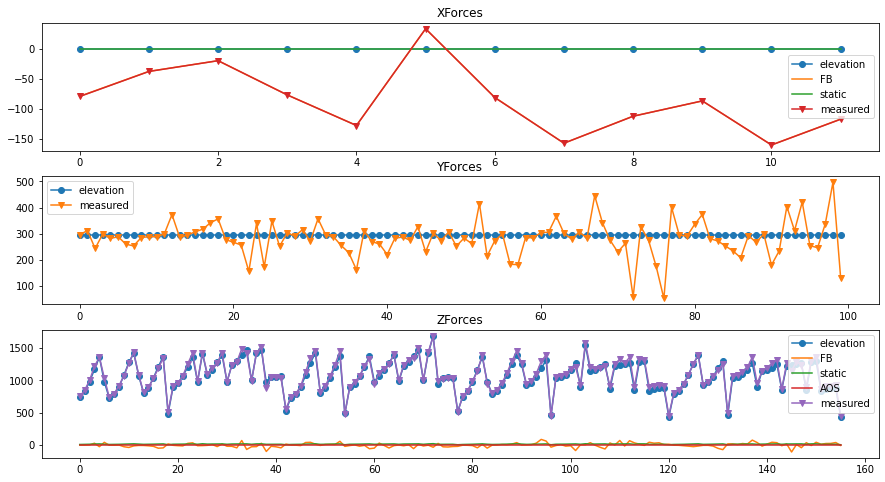

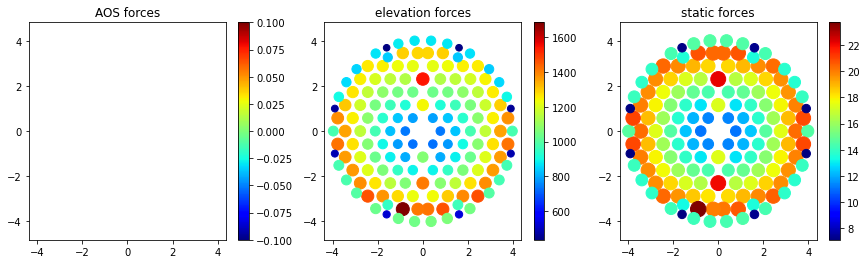

In [16]:
#%matplotlib inline
await plotM1M3Forces(m1m3)

### Get M2 Ready: turn on FB, clear forces

In [ ]:
#execute once to get the state OUT one level
if sstate.summaryState == salobj.State.ENABLED:
    await m2.cmd_disable.set_start()
if sstate.summaryState == salobj.State.DISABLED:
    await m2.cmd_standby.set_start()
#the below would shut down the CSC; be ready to restart it if you want to try.
if sstate.summaryState == salobj.State.STANDBY:
    await m2.cmd_exitControl.set_start()
sstate = await m2.evt_summaryState.next(flush=True, timeout=5)
print('starting with: m2 state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))

In [ ]:
#execute once to get the state UP one level
if sstate.summaryState == salobj.State.FAULT:
    await m2.cmd_clearErrors.set_start()
if sstate.summaryState == salobj.State.OFFLINE:
    await m2.cmd_enterControl.set_start()    
if sstate.summaryState == salobj.State.STANDBY:
    await m2.cmd_start.set_start() #go to DISABLE
if sstate.summaryState == salobj.State.DISABLED:
    await m2.cmd_enable.set_start() #go to ENABLE = closed loop
sstate = await m2.evt_summaryState.next(flush=True, timeout=5) 
print('starting with: m2 state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))

In [17]:
m2ForceBalance = await m2.evt_forceBalanceSystemStatus.aget(timeout=10.)
print("starting with Status of the M2 force balance system ---", m2ForceBalance.status, "----",
      pd.to_datetime(m2ForceBalance.private_sndStamp, unit='s'))
if not m2ForceBalance.status:
    await m2.cmd_switchForceBalanceSystem.set_start(status=True, timeout=10)
    m2ForceBalance = await m2.evt_forceBalanceSystemStatus.aget(timeout=10.)
    print("Status of the M2 force balance system", m2ForceBalance.status)

starting with Status of the M2 force balance system --- True ---- 2021-04-07 21:50:31.520246016


In [18]:
zAngle = await m2.tel_zenithAngle.next(flush=True, timeout=5)
print('zenith angle = ', zAngle.measured)

zenith angle =  9.960201842322498


In [19]:
fa = [0]*72
ft = [0]*6
await m2.cmd_applyForces.set_start(axial=fa, tangent=ft)

In [18]:
### no activeopticForces (or any other hunman-applied forces) to start with
await m2.cmd_resetForceOffsets.set_start()

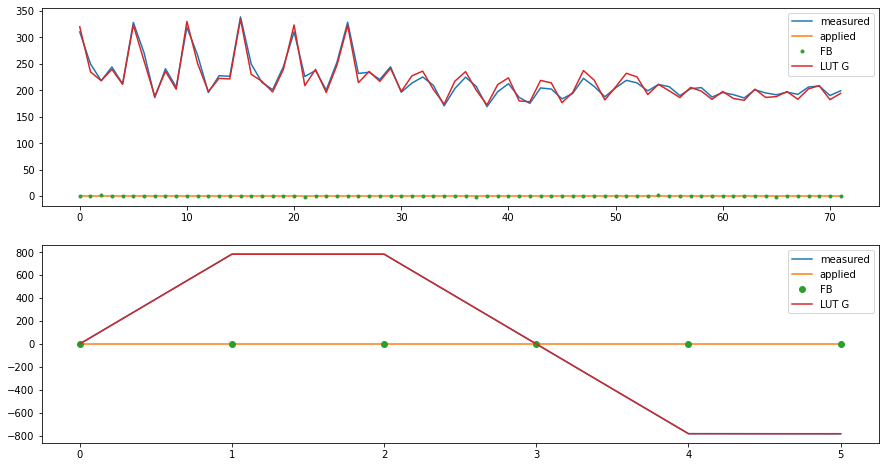

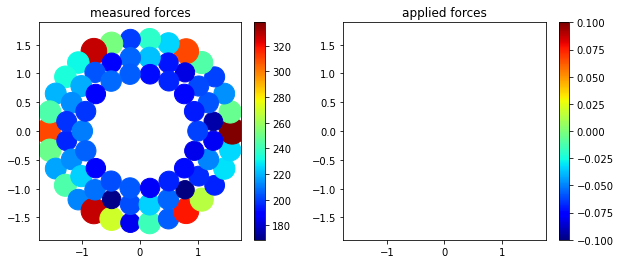

In [20]:
await plotM2Forces(m2)

### Get cam hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [21]:
await readyHexForAOS(camhex)

default.yaml:v0.7.1-0-ga27001c
compsensation mode enabled? True 2021-04-05 23:22:27.947217408
Does the hexapod has enough inputs to do LUT compensation?
79.99909810684058 358.5011650055287 0.2950311058107786 0.0
x,y,z,u,v,w =  -0.867999028888373 -423.40146401268555 283.364172082507 -0.01159182038209176 0.0 0.0


In [22]:
await printHexUncompensatedAndCompensated(camhex)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-04-08 00:20:33.593906944
Compensated position
     -0.87    -423.40     283.36      -0.011592   0.000000   0.000000    2021-04-08 00:20:33.594224640


In [32]:
#await camhex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True) #to avoid the timeout if it is already at 0.
#await asyncio.sleep(5.)
await moveHexTo0(camhex)

hex in position? False 2021-04-07 22:12:46.745937408
hex in position? True 2021-04-07 22:12:46.848579328
Current Hexapod position
     -0.83    -423.38     283.34  -0.011592   0.000000  -0.000000


In [ ]:
await printHexUncompensatedAndCompensated(camhex)

### Get M2 hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [23]:
await readyHexForAOS(m2hex)

default.yaml:v0.7.1-0-ga27001c
compsensation mode enabled? True 2021-04-06 00:57:47.000164864
Does the hexapod has enough inputs to do LUT compensation?
79.99909810684058 358.5011650055287 0.2950311058107786 0.0
x,y,z,u,v,w =  -2.5164531571896442 -369.4758057742772 301.77105392461385 -0.00436049397587662 0.0 0.0


In [24]:
await printHexUncompensatedAndCompensated(m2hex)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-04-08 00:20:33.595763712
Compensated position
     -2.52    -369.48     301.77      -0.004360   0.000000   0.000000    2021-04-08 00:20:33.596478208


In [36]:
#await m2hex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True) #to avoid the timeout if it is already at 0.
#await asyncio.sleep(5.)
await moveHexTo0(m2hex)

hex in position? False 2021-04-07 22:13:50.367454720
hex in position? True 2021-04-07 22:13:50.573339136
Current Hexapod position
     -2.50    -369.49     301.72  -0.004360   0.000000   0.000000


In [ ]:
await printHexUncompensatedAndCompensated(m2hex)

### Step 1: add aberrations via OFC

In [25]:
zernikes = np.zeros(19)
zerIdx = np.arange(4, 23)
zernikes[7-4] = 1 #add 1um of z7
print(zerIdx)
print(zernikes)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

10: Currently configured with <CamType.ComCam: 3>
10: Assuming white light filter to compute aberration.
10: Issue the M1M3 correction successfully.
10: Issue the M2 hexapod correction successfully.
20: Issue the M2 correction successfully.
10: Issue the camera hexapod correction successfully.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


2021-04-08 18:32:14.404395264


appliedActiveOpticForces DDS read queue is filling: 10 of 100 elements
appliedAberrationForces DDS read queue is filling: 10 of 100 elements
appliedForces DDS read queue is filling: 10 of 100 elements


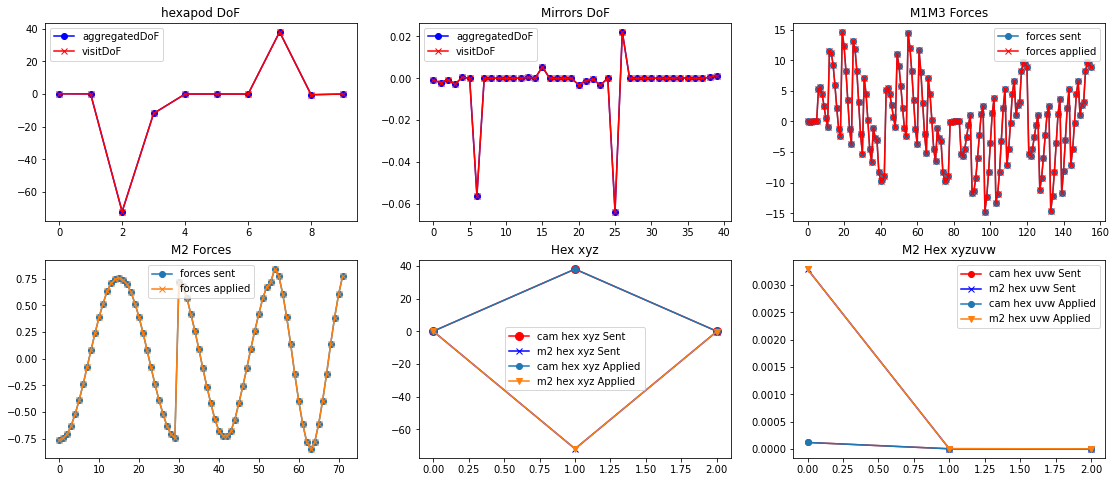

In [27]:
def compSentApplied(aos, m1m3, m2, camhex, m2hex):
    dof = aos.evt_degreeOfFreedom.get()
    m1m3C = aos.evt_m1m3Correction.get()
    m2C = aos.evt_m2Correction.get()
    camhexC = aos.evt_cameraHexapodCorrection.get()
    m2hexC = aos.evt_m2HexapodCorrection.get()
    print(pd.to_datetime(dof.private_sndStamp, unit='s'))
    fig, ax = plt.subplots(2,3, figsize=(19,8) )

    aa = np.array(dof.aggregatedDoF)
    vv = np.array(dof.visitDoF)

    ##--------------------------------------
    ax[0][0].plot(aa[:10],'-bo', label='aggregatedDoF')
    ax[0][0].plot(vv[:10],'-rx', label='visitDoF')
    ax[0][0].set_title('hexapod DoF')
    ax[0][0].legend()

    ax[0][1].plot(aa[10:], '-bo', label='aggregatedDoF')
    ax[0][1].plot(vv[10:],'-rx', label='visitDoF')
    ax[0][1].set_title('Mirrors DoF')
    ax[0][1].legend()

    ##--------------------------------------
    aa = m1m3.evt_appliedActiveOpticForces.get()
    ax[0][2].plot(m1m3C.zForces,'-o', label='forces sent')
    ax[0][2].plot(aa.zForces, '-rx', label='forces applied')
    ax[0][2].set_title('M1M3 Forces')
    ax[0][2].legend()

    aa = m2.tel_axialForce.get()
    ax[1][0].plot(m2C.zForces,'-o', label='forces sent')
    ax[1][0].plot(aa.applied, '-x', label='forces applied')
    ax[1][0].set_title('M2 Forces')
    ax[1][0].legend()

    ##--------------------------------------
    aa = np.array([getattr(camhexC,i) for i in ['x', 'y', 'z', 'u','v','w']])
    aam2 = np.array([getattr(m2hexC,i) for i in ['x', 'y', 'z', 'u','v','w']])
    uu = np.array([getattr(camhex.evt_uncompensatedPosition.get(),i) for i in ['x','y','z', 'u','v','w']])
    uum2 = np.array([getattr(m2hex.evt_uncompensatedPosition.get(),i) for i in ['u','v','z', 'u','v','w']])

    ax[1][1].plot(aa[:3], '-ro', label='cam hex xyz Sent', markersize=8)
    ax[1][1].plot(aam2[:3],'-bx', label='m2 hex xyz Sent')
    ax[1][1].plot(uu[:3], '-o',  label='cam hex xyz Applied')
    ax[1][1].plot(aam2[:3], '-v', label='m2 hex xyz Applied')
    ax[1][1].set_title('Hex xyz')
    ax[1][1].legend()

    ax[1][2].plot(aa[3:], '-ro', label='cam hex uvw Sent')
    ax[1][2].plot(aam2[3:], '-bx', label='m2 hex uvw Sent')
    ax[1][2].plot(uu[3:], '-o', label='cam hex uvw Applied')
    ax[1][2].plot(uum2[3:], '-v', label='m2 hex uvw Applied')
    ax[1][2].set_title('M2 Hex xyzuvw')
    ax[1][2].legend()
    
    return dof, aa, aam2, uu, uum2    

dof, camsent, m2sent, camrvd, m2rvd =  compSentApplied(aos, m1m3, m2, camhex, m2hex)

### Step 2: add same aberrations twice. Are the aggregateDOF accumulating?

In [28]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

10: Currently configured with <CamType.ComCam: 3>
10: Assuming white light filter to compute aberration.
20: Issue the M2 correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


2021-04-08 18:32:54.314443264


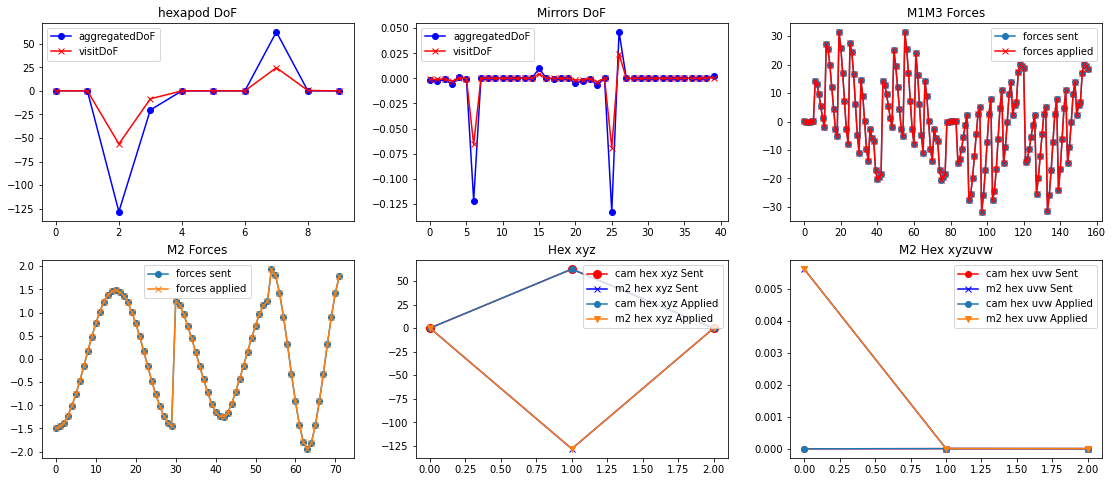

In [29]:
dof2, camsent2, m2sent2, camrvd2, m2rvd2 = compSentApplied(aos, m1m3, m2, camhex, m2hex)

This depends on the control strategy we are using. For x00, do not expect 2 or 1.

In [30]:
camsent2[:5]/camsent[:5]

array([ 1.5532443 ,  1.6490671 , 10.94577817, -0.0435523 ,  1.19623977])

In [31]:
m2sent2[:5]/m2sent[:5]

array([1.35653437, 1.78411044, 1.2802434 , 1.70934537, 1.49842256])

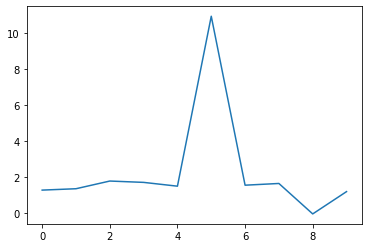

In [32]:
plt.plot(np.array(dof2.aggregatedDoF[:10])/np.array(dof.aggregatedDoF[:10]))

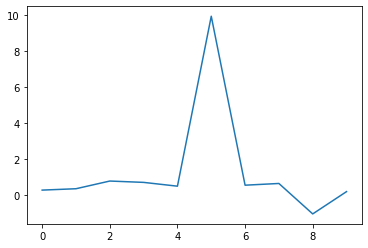

In [33]:
plt.plot(np.array(dof2.visitDoF[:10])/np.array(dof.visitDoF[:10]))

### Step 3: Reset the corrections

In [68]:
await aos.cmd_resetCorrection.set_start()

20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [69]:
##the following should be done by cmd_resetCorrection, but right now this is not the case
await aos.cmd_issueCorrection.set_start() 
#issue the resetted correction, which should be equivalent to the below
#await m1m3.cmd_applyActiveOpticForces.set_start(zForces=[0]*156)
#await m2.cmd_resetForceOffsets.set_start()
#await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)
#await m2hex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
20: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.


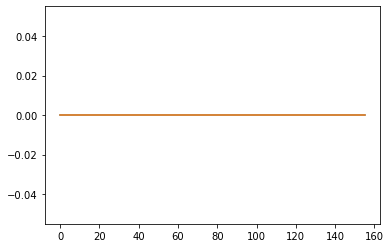

In [70]:
plt.plot(aos.evt_m1m3Correction.get().zForces)
plt.plot(m1m3.evt_appliedActiveOpticForces.get().zForces);

### Step 4: Double the aberration, do the corrections double? yes

In [71]:
zernikes[7-4] = 2 # z7 = 2um

In [72]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

10: Currently configured with <CamType.ComCam: 3>
10: Assuming white light filter to compute aberration.
10: Issue the M2 hexapod correction successfully.
20: Issue the M2 correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the camera hexapod correction successfully.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


2021-04-08 20:47:47.091545344


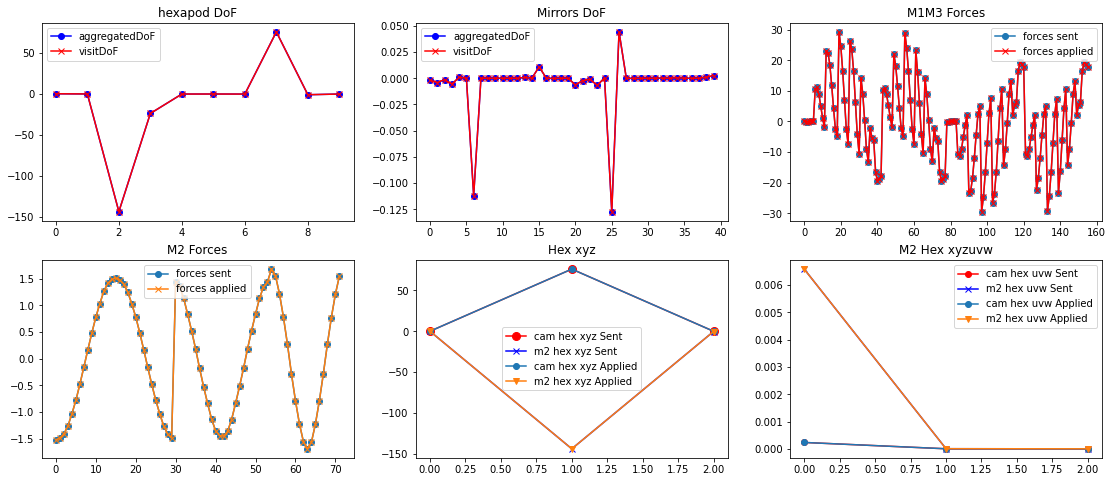

In [73]:
dof3, camsent3, m2sent3, camrvd3, m2rvd3 = compSentApplied(aos, m1m3, m2, camhex, m2hex)

In [40]:
camsent3[:5]/camsent[:5]

array([2., 2., 2., 2., 2.])

In [41]:
m2sent3[:5]/m2sent[:5]

array([2., 2., 2., 2., 2.])

### Step 5: Observe the corrections being rejected

In [74]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-04-08 20:49:17.976815616
m1m3 state DetailedState.PARKED 2021-04-08 20:50:10.861561088


In [ ]:
#save the forces and positions before attempting adding aberrations
m1m3F0 = m1m3.evt_appliedActiveOpticForces.get().zForces
m2F0 = m2.tel_axialForce.get().applied
camhexP0 = np.array([getattr(camhex.evt_uncompensatedPosition.get(),i) for i in ['x','y','z', 'u','v','w']])
m2hexP0 = np.array([getattr(m2hex.evt_uncompensatedPosition.get(),i) for i in ['u','v','z', 'u','v','w']])

In [77]:
#save MTAOS corrections before attempting adding aberrations
dofa0 = aos.evt_degreeOfFreedom.get().aggregatedDoF
dofv0 = aos.evt_degreeOfFreedom.get().visitDoF
m1m3C0 = aos.evt_m1m3Correction.get().zForces
m2C0 = aos.evt_m2Correction.get().zForces
camhexC0 = np.array([getattr(aos.evt_cameraHexapodCorrection.get(),i) for i in ['x','y','z', 'u','v','w']])
m2hexC0 = np.array([getattr(aos.evt_m2HexapodCorrection.get(),i) for i in ['x','y','z', 'u','v','w']])

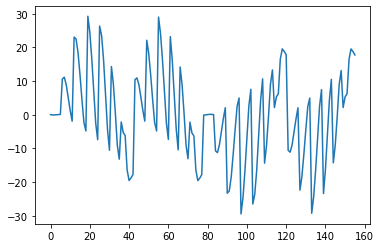

In [80]:
plt.plot(m1m3C0); #this should be same as plot above (a few cells back). We simply just saved the data

In [81]:
#Expect this command to be rejected, because M1M3 is parked
zernikes[7-4] = 1
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

10: Currently configured with <CamType.ComCam: 3>
10: Assuming white light filter to compute aberration.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
20: Issue the M2 correction successfully.
40: M1M3 correction command failed.
20: Execute pubEvent_rejectedM1M3Correction().
20: Execute pubEvent_rejectedDegreeOfFreedom().
30: Undoing m2 correction.
20: Issue the M2 correction successfully.
30: Undoing m2hex correction.
10: Issue the M2 hexapod correction successfully.
30: Undoing camhex correction.
10: Issue the camera hexapod correction successfully.


AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=122286167, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: Failed to apply correction to: ['m1m3']. ")

40: Callback <bound method MtaosCsc.do_addAberration of <lsst.ts.MTAOS.MtaosCsc.MtaosCsc object at 0x7fc4963785e0>> failed with data=private_revCode: 8adfd49b, private_sndStamp: 1617915281.7886188, private_rcvStamp: 1617915281.7892494, private_seqNum: 122286167, private_identity: Script:1, private_origin: 18331, private_host: 0, wf: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], config: 


#### the addAberration command is supposed to have undone corrections to M2, camhex, and m2hex. Let's check that

In [82]:
#save the forces and positions before attempting adding aberrations
m1m3F1 = m1m3.evt_appliedActiveOpticForces.get().zForces
m2F1 = m2.tel_axialForce.get().applied
camhexP1 = np.array([getattr(camhex.evt_uncompensatedPosition.get(),i) for i in ['x','y','z', 'u','v','w']])
m2hexP1 = np.array([getattr(m2hex.evt_uncompensatedPosition.get(),i) for i in ['u','v','z', 'u','v','w']])

In [83]:
print(np.array(m1m3F1)- np.array(m1m3F0))
print(np.array(m2F1)- np.array(m2F0))
print(camhexP1-camhexP0)
print(m2hexP1-m2hexP0)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 3.72892617  3.64232196  3.45458465  3.08966624  2.54910688  1.92537775
  1.19224028  0.39640276 -0.4132857  -1.19686838 -1.91768435 -2.54194091
 -3.09569351 -3.47296537 -3.65745856 -3.72575479 -3.62636038 -3.43127332
 -3.0684216  -2.53931036 -1.93113243 -1.21085044 -0.41981703  0.39197167
  1.18033801  1.90501343  2.52932281  3.08097602  3.45836997  3.64919137
 -3.20276275 -2.99974074 -2.51593423 -1.85046548 -1.14884056 -0.40152911
  0.39333674  1.14698281  1.84904148  2.5043944   2.98132634  3.19532
  3.21008727  3.

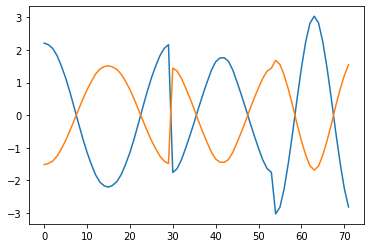

In [51]:
plt.plot(m2F1)
plt.plot(m2F0);

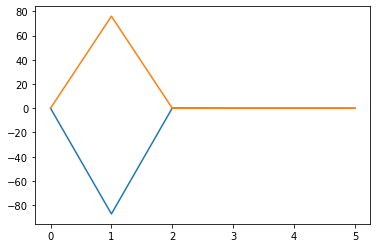

In [52]:
plt.plot(camhexP1)
plt.plot(camhexP0)

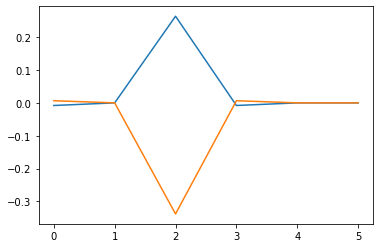

In [53]:
plt.plot(m2hexP1)
plt.plot(m2hexP0)

#### What about MTAOS corrections?

In [54]:
dofa1 = aos.evt_degreeOfFreedom.get().aggregatedDoF
dofv1 = aos.evt_degreeOfFreedom.get().visitDoF
m1m3C1 = aos.evt_m1m3Correction.get().zForces
m2C1 = aos.evt_m2Correction.get().zForces
camhexC1 = np.array([getattr(aos.evt_cameraHexapodCorrection.get(),i) for i in ['x','y','z', 'u','v','w']])
m2hexC1 = np.array([getattr(aos.evt_m2HexapodCorrection.get(),i) for i in ['x','y','z', 'u','v','w']])

In [61]:
print(np.array(dofa1)-np.array(dofa0))
print(np.array(dofv1)-np.array(dofv0))
print(np.array(m1m3C1)-np.array(m1m3C0))
print(np.array(m2C1)-np.array(m2C0))
print(np.array(camhexC1)-np.array(camhexC0))
print(np.array(m2hexC1)-np.array(m2hexC0))
#The expectation is that these have changed even when the command got rejected. ??
#We need the rejectCorrection command to MTAOS to the correction from last visit. ??

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

### rejectCorrection 

This makes sure OFC does proper accounting when commands are rejected.

In [62]:
await aos.cmd_rejectCorrection.set_start()

20: Execute do_rejectCorrection().
20: Execute pubEvent_rejectedDegreeOfFreedom().


In [63]:
dofa2 = aos.evt_degreeOfFreedom.get().aggregatedDoF
dofv2 = aos.evt_degreeOfFreedom.get().visitDoF
m1m3C2 = aos.evt_m1m3Correction.get().zForces
m2C2 = aos.evt_m2Correction.get().zForces
camhexC2 = np.array([getattr(aos.evt_cameraHexapodCorrection.get(),i) for i in ['x','y','z', 'u','v','w']])
m2hexC2 = np.array([getattr(aos.evt_m2HexapodCorrection.get(),i) for i in ['x','y','z', 'u','v','w']])

In [64]:
print(np.array(dofa2)-np.array(dofa0))
print(np.array(dofv2)-np.array(dofv0))
print(np.array(m1m3C2)-np.array(m1m3C0))
print(np.array(m2C2)-np.array(m2C0))
print(np.array(camhexC2)-np.array(camhexC0))
print(np.array(m2hexC2)-np.array(m2hexC0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
## check the forces and hexapod motions

### Close up

In [ ]:
#if we started with enabled state, we need to put it back
await salobj.set_summary_state(m1m3, salobj.State.ENABLED,  settingsToApply='Default')

In [ ]:
await salobj.set_summary_state(mount, salobj.State.ENABLED)

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)